# Latent Space Models for Brain Networks


In [1]:
import os
import sys
import pickle
import datetime
sys.path.append(os.path.abspath(".."))

import numpy as np
import numpy.random as npr
from scipy.misc import logsumexp
npr.seed(0)

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("paper")
colors = sns.xkcd_palette(
    ["red",
     "windows blue",
     "amber",
     "faded green",
     "dusty purple",
     "orange",
     "clay",
     "midnight"
    ])

from hips.plotting.layout import create_axis_at_location, remove_plot_labels
from hips.plotting.colormaps import gradient_cmap

from lsm import LatentSpaceModel, LatentSpaceModelWithShrinkage, \
    MixtureOfLatentSpaceModels, MixtureOfLatentSpaceModelsWithShrinkage, \
    FactorialLatentSpaceModel
    
from lsm.utils import random_mask, cached, progprint_xrange, white_to_color_cmap

In [2]:
# Store the model fits so that we don't have to rerun them all the time
results_basedir = os.path.join("..", "results")
assert os.path.exists(results_basedir), "'results' directory must exist in project root."

# By default, store results in results/yyyy_mm_dd directory for today
# Override this if you want to perform many runs
# today = datetime.date.today()
# results_dir = os.path.join(results_basedir, today.strftime("%Y_%m_%d"))
# if not os.path.exists(results_dir):
#     print("Making directory for today's results: ", results_dir)
#     os.mkdir(results_dir)
results_dir = os.path.join(results_basedir, "2017_06_16")

In [3]:
missing_frac = 0.25
N_itr = 500
Ks = np.arange(2, 21, 2, dtype=int)
H = 10
sigmasq_b = 1.0

In [24]:
# Load the KKI-42 dataset
datapath = os.path.join("..", "data", "kki-42-data.pkl")
assert os.path.exists(datapath)
with open(datapath, "rb") as f:
    As = pickle.load(f)

N, Vorig, _ = As.shape
assert N == 42 and Vorig == 70 and As.shape[2] == Vorig
bad_indices = [0, 35]
good_indices = np.array(sorted(list(set(np.arange(Vorig)) - set(bad_indices))))
As = As[np.ix_(np.arange(N), good_indices, good_indices)]
V = Vorig - len(bad_indices)

# Sample random masks
masks = [random_mask(V, missing_frac) for _ in range(N)]

# Compute number of train/test edges
L = np.tril(np.ones((V, V), dtype=bool), k=-1)
N_train = np.sum([mask * L for mask in masks])
N_test = np.sum([(1- mask) * L for mask in masks])

print("N: ", N)
print("V: ", V)
print("Num edges: ", N * V * (V-1) / 2)
print("Num train: ", N_train)
print("Num test:  ", N_test)

N:  42
V:  68
Num edges:  95676.0
Num train:  71774
Num test:   23902


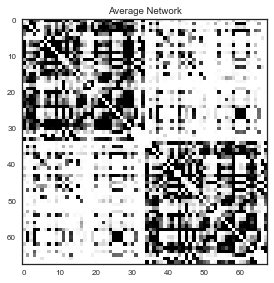

In [5]:
# Plot the mean network
plt.imshow(As.mean(0), vmin=0, vmax=1, interpolation="nearest")
plt.title("Average Network")

# Fit the models

In [6]:
def fit(model, name):
    print("Fitting ", name)
    lls = []
    hlls = []
    ms = []
    for itr in progprint_xrange(N_itr):
        model.resample()
        lls.append(model.log_likelihood())
        hlls.append(model.heldout_log_likelihood())
        ms.append(model.ms.copy())
    return model, np.array(lls), np.array(hlls), np.array(ms)

def run_experiments(experiments):
    results = []
    for model, name in experiments:
        for A, mask in zip(As, masks):
            model.add_data(A, mask=mask)
        model.initialize()
        
        _fit = cached(results_dir, name)(fit)
        results.append(_fit(model, name))
    return results

In [7]:
# Baseline model
_, baseline_ll, baseline_hll, _  = \
    run_experiments([(LatentSpaceModel(V, 0), "Bernoulli")])[0]
baseline_ll = np.mean(baseline_ll[N_itr//2:])
baseline_hll = np.mean(baseline_hll[N_itr//2:])

In [8]:
# Standard model
std_experiments = []
for K in Ks:
    model = LatentSpaceModel(V, K, sigmasq_b=sigmasq_b)
    name = "standard_lsm_K{}".format(K)
    std_experiments.append((model, name))

std_results = run_experiments(std_experiments)

In [9]:
# Standard model with shrinkage prior
std_shr_experiments = []
for K in Ks:
    model = LatentSpaceModelWithShrinkage(V, K, sigmasq_b=sigmasq_b, a1=3.5, a2=2.5)
    name = "standard_lsm_shrink_K{}".format(K)
    std_shr_experiments.append((model, name))

std_shr_results = run_experiments(std_shr_experiments)

In [10]:
# Mixture of latent space models 
mix_experiments = []
for K in Ks:
    model = MixtureOfLatentSpaceModels(V, K*H, H=H, sigmasq_b=sigmasq_b)
    name = "mixture_lsm_K{}_H{}".format(K, H)
    mix_experiments.append((model, name))

mix_results = run_experiments(mix_experiments)

In [11]:
# Mixture of latent space models with shrinkage prior
mix_shr_experiments = []
for K in Ks:
    model = MixtureOfLatentSpaceModelsWithShrinkage(V, K*H, H=H, sigmasq_b=sigmasq_b, a1=3.5, a2=2.5)
    name = "mixture_lsm_shrink_K{}_H{}".format(K, H)
    mix_shr_experiments.append((model, name))

mix_shr_results = run_experiments(mix_shr_experiments)

In [12]:
# Factorial latent space models
fac_experiments = []
for K in Ks:
    model = FactorialLatentSpaceModel(V, K, sigmasq_b=sigmasq_b, alpha=1 + K / 2.0)
    name = "factorial_lsm_K{}".format(K)
    fac_experiments.append((model, name))
    
fac_results = run_experiments(fac_experiments)

# Check convergence

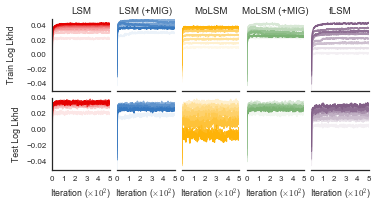

In [44]:
fig = plt.figure(figsize=(5.2, 2.8))
for j, (experiments, results) in \
    enumerate(zip([std_experiments, std_shr_experiments, 
                   mix_experiments, mix_shr_experiments, 
                   fac_experiments],
                  [std_results, std_shr_results, 
                   mix_results, mix_shr_results,
                   fac_results])):

    # Plot training log likelihoods
    axj = create_axis_at_location(fig, 0.6 + .9 * j, 1.6, .8, 1.0, box=False)
    for K, (_, name), (_, lls, _, _) in zip(Ks, experiments, results):
        color = white_to_color_cmap(colors[j])(K / Ks[-1])
        axj.plot(np.arange(N_itr), (lls - baseline_ll) / N_train, color=color)
        
        if j > 0:
            axj.spines['left'].set_visible(False)
            plt.tick_params(
                axis='y',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                left='off',        # ticks along the bottom edge are off
                right='off',
                labelleft='off')
        else:
            axj.set_ylabel("Train Log Lkhd", labelpad=10)

        axj.set_xticks([])
        axj.set_title(titles[j])
        

    # Plot test log likelihoods
    axj = create_axis_at_location(fig, 0.6 + .9 * j, .5, 0.8, 1.0, box=False)
    for K, (_, name), (_, _, hlls, _) in zip(Ks, experiments, results):
        color = white_to_color_cmap(colors[j])(K / Ks[-1])
        axj.plot(np.arange(N_itr) / 100 , (hlls - baseline_hll) / N_test, color=color)

    axj.set_xlabel("Iteration ($\\times 10^2$)")

    if j > 0:
        axj.spines['left'].set_visible(False)
        plt.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left='off',        # ticks along the bottom edge are off
            right='off',
            labelleft='off')
    else:
        axj.set_ylabel("Test Log Lkhd")
        
plt.savefig(os.path.join(results_dir, "convergence.pdf"))
plt.savefig(os.path.join(results_dir, "convergence.png"), dpi=300)

# Plot likelihood of train and test data
We see that the mixture of LSMs overfits the training data in the absence of a strong, sparsity-inducing prior.  With the prior, its predictive performance is comparable to that of the standard LSM.  The factorial model, by contrast, achieves significantly better predictive performance without suffering from overfitting.

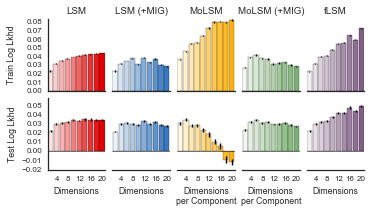

In [35]:
fig = plt.figure(figsize=(5.2, 2.8))
titles = ["LSM",
          "LSM (+MIG)",
          "MoLSM",
          "MoLSM (+MIG)",
          "fLSM"]

# Normalize by the number of terms in log likelihood
L = np.tril(np.ones((V, V), dtype=bool), k=-1)
N_train = np.sum([mask * L for mask in masks])
N_test = np.sum([(1- mask) * L for mask in masks])

for j, (experiments, results) in \
    enumerate(zip([std_experiments, std_shr_experiments, 
                   mix_experiments, mix_shr_experiments, 
                   fac_experiments],
                  [std_results, std_shr_results, 
                   mix_results, mix_shr_results,
                   fac_results])):
        
    axj = create_axis_at_location(fig, 0.6 + .9 * j, 1.6, 0.8, 1.0, box=False)
    for K, (_, name), (_, lls, _, _) in zip(Ks, experiments, results):
        color = white_to_color_cmap(colors[j])(K / Ks[-1])
        axj.bar(K, (np.mean(lls[N_itr // 2:]) - baseline_ll) / N_train, 
                yerr=np.std(lls[N_itr // 2:]) / N_train,  
                width=1.8, color=color, ecolor='k')
        axj.set_ylim(0, 6000. / N_train)
        axj.set_xlim(Ks[0], Ks[-1]+2)
        axj.set_xticks(Ks[::2])
        axj.set_xticks([])
        
    if j > 0:
        axj.spines['left'].set_visible(False)
        plt.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left='off',        # ticks along the bottom edge are off
            right='off',
            labelleft='off')
    else:
        axj.set_ylabel("Train Log Lkhd", labelpad=10)
    axj.set_title(titles[j])
    
    # Plot heldout log likelihoods
    axj = create_axis_at_location(fig, 0.6 + .9 * j, .5, 0.8, 1.0, box=False)
    for K, (_, name), (_, _, hlls, _) in zip(Ks, experiments, results):
        color = white_to_color_cmap(colors[j])(K / Ks[-1])
        axj.bar(K, (np.mean(hlls[N_itr // 2:]) - baseline_hll) / N_test,
                yerr=np.std(hlls[N_itr // 2:]) / N_test,  
                width=1.8, color=color, ecolor='k')
    axj.plot([Ks[0]-.2, Ks[-1]+2], [0, 0], '-k', lw=0.5)
    axj.set_ylim(-500. / N_test, 1400. / N_test)
    axj.set_xlim(Ks[0]-.2, Ks[-1]+2)
    axj.set_xticks(np.arange(4, 21, 4)+1)
    axj.set_xticklabels(np.arange(4, 21, 4))
    
    if titles[j].startswith("Mo"):
        axj.set_xlabel("Dimensions\nper Component")
    else:
        axj.set_xlabel("Dimensions")
        
    if j > 0:
        axj.spines['left'].set_visible(False)
        plt.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left='off',        # ticks along the bottom edge are off
            right='off',
            labelleft='off')
    else:
        axj.set_ylabel("Test Log Lkhd")
    
plt.savefig(os.path.join(results_dir, "lls.pdf"))
plt.savefig(os.path.join(results_dir, "lls.png"), dpi=300)

In [14]:
print("Baseline train pr per edge: ", np.exp(baseline_ll / N_train))
print("Factorial train pr per edge: ", np.exp(baseline_ll / N_train + 0.08))

print("Baseline test pr per edge: ", np.exp(baseline_hll / N_test))
print("Factorial test pr per edge: ", np.exp(baseline_hll / N_test + 0.05))

Baseline train pr per edge:  0.778371595062
Factorial train pr per edge:  0.843199882776
Baseline test pr per edge:  0.765779023907
Factorial test pr per edge:  0.805041354045


# Look at the inferred factors

In [15]:
# exaggerate the colormap by pushing values toward lim
logistic = lambda u: 1 / (1 + np.exp(-u))
logit = lambda p: np.log(p / (1-p))
class LogisticNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, clip=False, lim=1, scale=3.0):
        self.lim = lim
        self.scale = scale
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        z = (value + self.lim) / (2 * self.lim)
        zhat = logistic(self.scale * logit(z))
        return np.ma.masked_array(zhat)


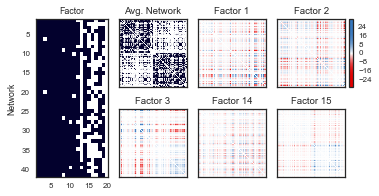

In [16]:
# Sort factors by variance (for used columns only)
fac_lsm_K20 = fac_results[-1][0]
M = np.array(fac_lsm_K20.ms)
used = M.sum(0) > 0
lmbda = np.var(fac_lsm_K20.X, axis=0)
perm = np.argsort(lmbda * used)[::-1]
X = fac_lsm_K20.X[:,perm]
XXTs = np.array([np.outer(X[:,k], X[:,k].T) for k in range(fac_lsm_K20.K)])
lim = np.max(abs(XXTs[:10]))

# Plot the factor usage
dark_cmap = white_to_color_cmap(colors[-1])
fig = plt.figure(figsize=(5.2,2.8))
ax0 = create_axis_at_location(fig, 0.4, 0.4, 1., 2.2 )
ax0.imshow(M[:,perm], interpolation="nearest", aspect="auto", 
           extent=(1,20,N,1), cmap=dark_cmap)
ax0.set_ylabel("Network")
ax0.set_xlabel("Factor")
ax0.xaxis.set_label_position('top') 

# Plot the average network
ax1 = create_axis_at_location(fig, 1.55, 1.65, .95, .95 )
Amean = As.mean(0)
np.fill_diagonal(Amean, 0)
ax1.imshow(Amean, vmin=0, vmax=1, interpolation="nearest", cmap=dark_cmap)
ax1.set_title("Avg. Network")
ax1.set_xticks([])
ax1.set_yticks([])

# Plot the outer product of individual factors
factors_to_plot = [0, 1, 2, 13, 14]
cmap = gradient_cmap([colors[0], np.ones(3), colors[1]])
for j in range(2):
    axj = create_axis_at_location(fig, 2.65 + 1.1 * j, 1.65, .95, .95 )
    XXTj = XXTs[factors_to_plot[j]]
    np.fill_diagonal(XXTj, 0)
    im = axj.imshow(XXTj, interpolation="nearest", 
               vmin=-lim, vmax=lim, cmap=cmap, 
               norm=LogisticNormalize(lim=lim, scale=3))
    axj.set_xticks([])
    axj.set_yticks([])
    axj.set_title("Factor {}".format(factors_to_plot[j]+1))

# Plot colorbar
ax_cb = create_axis_at_location(fig, 4.75, 1.65, 0.05, .95)
fig.add_axes(ax_cb)
plt.colorbar(im, cax=ax_cb)
    
for j in range(2, 5):
    axj = create_axis_at_location(fig, 1.55 + 1.1 * (j-2), .4, .95, .95 )
    XXTj = XXTs[factors_to_plot[j]]
    np.fill_diagonal(XXTj, 0)
    axj.imshow(XXTj, interpolation="nearest", 
               vmin=-lim, vmax=lim, cmap=cmap, 
               norm=LogisticNormalize(lim=lim, scale=3))
    axj.set_xticks([])
    axj.set_yticks([])
    axj.set_title("Factor {}".format(factors_to_plot[j]+1))
                      
plt.savefig(os.path.join(results_dir, "factors.pdf"))
plt.savefig(os.path.join(results_dir, "factors.png"), dpi=300)

In [52]:
# Look at mixture assignments
mix_results[-1][-1][-1][:,::Ks[-1]].sum(0)

array([ 5,  4,  2,  4,  2,  2, 12,  2,  3,  6])